In [285]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
%matplotlib inline

In [287]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [288]:
df = pd.read_csv('./test.csv')

In [289]:
print(df.shape)
print(df.columns.to_list())
print(df.iloc[0])

(5000, 29)
['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price']
listing_id                                                     1029166
title                         BMW X6 xDrive35i Sunroof (New 10-yr COE)
make                                                               bmw
model                                                               x6
description          owner consignment unit, viewing strictly by ap...
manufactured                                                    2012.0
original_reg_date                                                  NaN
reg_date                                                   27-jun-2012
type_of_vehicle                       

In [290]:
d1 = df['manufactured'].isnull()
df['age'] = df['manufactured'].copy()
df['age'][d1] = df['manufactured'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['original_reg_date'][d1]
def month(x):
    if pd.isna(x):
        return np.nan
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return (2021 - int(x)) * 12
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

def filterNeg(x):
    if x < 0:
        return 0
    return x
    
df['age'] = df['age'].map(month)

d1 = df['reg_date'].isnull()
df['remaining_coe'] = df['reg_date'].copy()
df['remaining_coe'][d1] = df['reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['original_reg_date'][d1]
d1 = df['remaining_coe'].isnull()
df['remaining_coe'][d1] = df['manufactured'][d1]
df['remaining_coe'] = 120 - df['remaining_coe'].map(month)
df['remaining_coe'] = df['remaining_coe'].map(filterNeg)

hasLifeSpan = ~df['lifespan'].isnull()
def get_remaining(x):
    diffFrom2021 = month(x)
    res = -diffFrom2021
    if res < 0:
        res = 0
    return res ##check 2021
df['remaining_coe'][hasLifeSpan] = df['lifespan'][hasLifeSpan].map(get_remaining)


G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
G:\software

In [291]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   listing_id         5000 non-null   int64  
 1   title              5000 non-null   object 
 2   make               4373 non-null   object 
 3   model              5000 non-null   object 
 4   description        4889 non-null   object 
 5   manufactured       4939 non-null   float64
 6   original_reg_date  100 non-null    object 
 7   reg_date           4939 non-null   object 
 8   type_of_vehicle    5000 non-null   object 
 9   category           5000 non-null   object 
 10  transmission       5000 non-null   object 
 11  curb_weight        4844 non-null   float64
 12  power              4325 non-null   float64
 13  fuel_type          1051 non-null   object 
 14  engine_cap         4985 non-null   float64
 15  no_of_owners       4944 non-null   float64
 16  depreciation       4868 

In [292]:
from collections import defaultdict
df_valid = df.dropna(subset = ['omv'])
omvs = df_valid['omv'].to_numpy()


# missingOmvModelsAge (1 year)
# missingomv = avg(modelAgeToSimilarOmv)
missingOmv = df.omv.isnull()
dfm = df[missingOmv]
missingModelAge = []
for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    missingModelAge.append(p)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    age = row['age']
    omv = row['omv']
    p = (model, age)
    mapper[p].append(omv)

for idx, row in dfm.iterrows():
    model = row['model']
    age = row['age']
    p = (model, age)
    df.at[idx, 'omv'] = np.average(mapper[p])

G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [293]:
missingOmv = df.omv.isnull()
#df['dereg_value'][missingOmv] = df['price'] * 0.7 ##check
df['omv'][missingOmv] = df['dereg_value']
df['omv'][df.omv.isnull()] = 80000

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


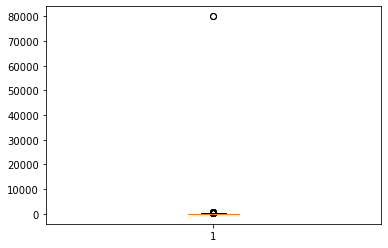

In [294]:
plt.boxplot(df_['age'])
plt.show()

In [295]:
print(df[df.age > 20000])

Empty DataFrame
Columns: [listing_id, title, make, model, description, manufactured, original_reg_date, reg_date, type_of_vehicle, category, transmission, curb_weight, power, fuel_type, engine_cap, no_of_owners, depreciation, coe, road_tax, dereg_value, mileage, omv, arf, opc_scheme, lifespan, eco_category, features, accessories, indicative_price, age, remaining_coe]
Index: []

[0 rows x 31 columns]


In [296]:
df['age'].max()

828

In [297]:
df['age'][df.age < 0] = 0

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [298]:
median = np.median(df['mileage'].dropna())
df['mileage'][df.mileage.isnull()] = median

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## estimated omv
from sklearn.linear_model import LinearRegression
df_ = df.copy()
df_ = df_.dropna(subset=['omv', 'age', 'price'])
omv = np.array(df_['price']).reshape(-1, 1)
# omv = omv[:100]
age = np.array(df_['age']).reshape(-1, 1)
# age = age[:100]
X = np.concatenate((omv, age), axis=1)
y = np.array(df_['omv']).reshape(-1, 1)
# y = y[:100]
# print(X.shape, y.shape)
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_)
# reg.predict(np.array([[3, 5]]))

In [299]:
df_valid = df.dropna(subset = ['power'])
ps = df_valid['power'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['power']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'power'] = np.average(mapper[model])

print(df['power'].isnull().sum())

487


G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [300]:
df_valid = df.dropna(subset = ['engine_cap'])
ps = df_valid['engine_cap'].to_numpy()

missingPs = df.power.isnull()
dfm = df[missingPs]
missingPower = []
for idx, row in dfm.iterrows():
    model = row['model']
    missingPower.append(model)

mapper = defaultdict(list)
for idx, row in df_valid.iterrows():
    model = row['model']
    power = row['engine_cap']
    mapper[model].append(power)

for idx, row in dfm.iterrows():
    model = row['model']
    df.at[idx, 'engine_cap'] = np.average(mapper[model])

print(df['engine_cap'].isnull().sum())

15


G:\softwares\envs\4277lab\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
G:\softwares\envs\4277lab\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [301]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    p, e = row['power'], row['engine_cap']
    
    if type(row["power"]) == float and pd.isna(row["power"]):
        diff = np.abs(caps - e)

        indices = np.argsort(diff)[:k]

        k_powers = powers[indices]

        avg = np.average(k_powers)

        # Set the weight value of the current row to the median
        df.at[idx, 'power'] = avg

In [302]:
df_valid = df.dropna(subset = ['power', 'engine_cap'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

k = 10
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']
    
    if type(row["engine_cap"]) == float and pd.isna(row["engine_cap"]):

        diff = np.abs(powers - p)

        indices = np.argsort(diff)[:k]

        k_caps = caps[indices]

        avg = np.average(k_caps)

        # Set the weight value of the current row to the median
        df.at[idx, 'engine_cap'] = avg

0


# fill omv, get data with missing omv and dereg_value, fill in the omv
is_ = df[df.omv.isnull() & df.dereg_value.isnull()].index.tolist()
filled_omvs = []
for idx in is_:
    ag = df.at[idx, 'age']
    price = df.at[idx, 'price']
    mo = reg.predict(np.array([[ag, price]]))
    filled_omvs.append(mo)
for i, idx in enumerate(is_):
    df.at[idx, 'omv'] = filled_omvs[i]

In [303]:
avg = np.average(df['coe'].dropna())
df['coe'] = df['coe'].fillna(avg)

In [304]:
# coe: fill in missing value for coe according to: age and power
fill_arf = df[df.arf.isnull() & df.dereg_value.isnull()]['arf'].index.tolist()
for idx in fill_arf:
    omv = df.at[idx, 'omv']
    if omv < 20000:
        df.at[idx, 'arf'] = omv
    elif omv >= 20000 and omv <= 50000:
        df.at[idx, 'arf'] = (omv - 20000) * 1.40 + 20000
    else:
        df.at[idx, 'arf'] =  (omv - 50000) * 1.80 + 62000
print(len(df[df.arf.isnull() & df.dereg_value.isnull()]))
# df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

0


In [305]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

0


In [306]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        if t in t_to_coe:
            l = t_to_coe[t]
            if len(l) > 0:
                avg = sum(l) / len(l)
                df.at[idx, 'coe'] = avg
                c += 1
print(c)

0
0


In [308]:
import math
for idx, row in df.iterrows():
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        coe_rebate = coe * row['remaining_coe'] / 120
        dereg_value = parf_ratio * arf + coe_rebate
        if dereg_value <= 0:
            dereg_value = 0
        df.at[idx, "dereg_value"] = dereg_value

In [310]:
# drop irrelevant
df = df.drop(columns = ['title', 'make', 'model', 'description', 'arf', 'original_reg_date','reg_date', 'opc_scheme', 'listing_id', 'indicative_price', 'manufactured', 'no_of_owners', 'lifespan', 'eco_category', 'accessories', 'depreciation', 'road_tax', 'features'])

In [311]:
df = df.drop(columns = ['curb_weight', 'fuel_type'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type_of_vehicle  5000 non-null   object 
 1   category         5000 non-null   object 
 2   transmission     5000 non-null   object 
 3   power            5000 non-null   float64
 4   engine_cap       5000 non-null   float64
 5   coe              5000 non-null   float64
 6   dereg_value      5000 non-null   float64
 7   mileage          5000 non-null   float64
 8   omv              5000 non-null   float64
 9   age              5000 non-null   int64  
 10  remaining_coe    5000 non-null   int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 429.8+ KB


In [312]:
df.to_csv('numerical_cleaned_test.csv')  

In [318]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_train, y_train))
y_pred = reg.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
print(mse)

0.8189174189684556
2343473176.827915


In [322]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor().fit(X_train,y_train)


In [323]:
y_pred = model.predict(X_test)
mse=mean_squared_error(y_test, y_pred)
print(mse)

1648947786.4227123


In [371]:
model.fit(X, y)



AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [397]:
avg = np.average(df['dereg_value'].dropna())
df['dereg_value'] = df['dereg_value'].fillna(avg)
final_X = df.to_numpy()
print(df.isnull().values.any())
df.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   power         5000 non-null   float64
 1   depreciation  5000 non-null   float64
 2   road_tax      5000 non-null   float64
 3   dereg_value   5000 non-null   float64
 4   mileage       5000 non-null   float64
 5   trans         5000 non-null   int64  
 6   ordinal_type  5000 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 273.6 KB


In [398]:
y = model.predict(final_X)
y = pd.DataFrame(y)
y.to_csv('predictions.csv')